# CNN Pipeline for Handwritten Digit Classifcation of the MNIST Dataset

**Course:** DVAE26 HT25  
  
**Author** Samuel Lindvall 



## Imports


In [ ]:
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader

#Torchvision 
from torchvision import datasets, transforms

#Evaluation
from sklearn.metrics import confusion_matrix, classification_report


## Constants for training

In [ ]:
#Configuration
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10

## 1. Problem Definition

The goal of this project is to classify grayscale images of handwritten digits (0–9) using a Convolutional Neural Network (CNN).
Each image has a resolution of 28×28 pixels.

**Input:** 28×28 grayscale image  
  
**Output:** Digit label (0–9) 

## 2. Dataset Overview and Data Quality Analysis

The MNIST dataset consists of 70,000 labeled images of handwritten digits:
- 60,000 training samples
- 10,000 test samples



First step is defining the transform for PyTorch and loading the dataset 

In [ ]:
#Step one is defining a transformation that converts the data into a PyTorch tensor
#The pixel values are normalized between [0,1]

transform = transforms.Compose([
    transforms.ToTensor()
])

#Using the MNIST class in torchvision we load the training dataset 
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=False, #Set to true unless kaggle dataset
    transform=transform
)

#Using the MNIST class in torchvision we load the test dataset 
test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=False, #The dataset is alerady downloaded from kaggle
    transform=transform
)

Let's start by examining the data and confirming the datasets sizes

In [4]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


image, label = train_dataset[0]
print("Min pixel value:", image.min().item())
print("Max pixel value:", image.max().item())


print("Shape:", image.shape)

Number of training samples: 60000
Number of test samples: 10000
Min pixel value: 0.0
Max pixel value: 1.0
Shape: torch.Size([1, 28, 28])


These are confirmed to be correct with 60000 training samples
and 10000 test samples. 
The pixel values are normalized as expected.
A single image has the shape of [1, 28, 28] where is the channel dimension (1=grayscale) and it's 28x28.

Now let's visualize the data by looking at the first 5 digits of the training set:

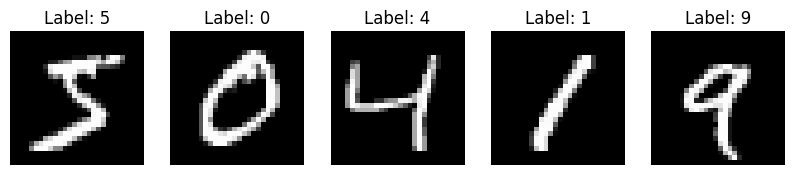

In [5]:

fig, axes = plt.subplots(1,5, figsize=(10,2))
for i, ax in enumerate(axes):
    image, label = train_dataset[i]
    ax.imshow(image.squeeze(), cmap="gray") #Important to remove the channel dimension for imshow
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()

A simple check for missing or invalid values:

In [6]:
def check_missing_or_invalid(dataset, name="Dataset"):
    missing_count = 0
    nan_count = 0
    for i in range(len(dataset)):
        image, label = dataset[i]
        if image is None or label is None:
            missing_count += 1
        if torch.isnan(image).any() or torch.isinf(image).any():
            nan_count += 1
    print(f"{name} -> Missing samples: {missing_count}, NaN/Inf values: {nan_count}")

# Run checks
check_missing_or_invalid(train_dataset, "Training Set")
check_missing_or_invalid(test_dataset, "Test Set")


Training Set -> Missing samples: 0, NaN/Inf values: 0
Test Set -> Missing samples: 0, NaN/Inf values: 0


Let's have a look at the distribution of the dataset to make sure we have a somewhat equal representation of digits:

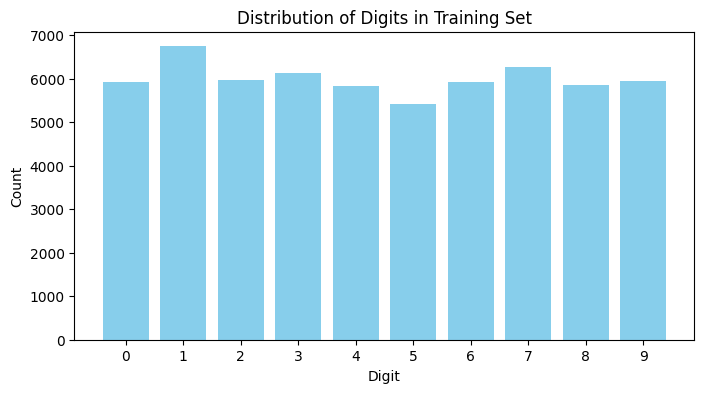

In [7]:
labels = [label for _, label in train_dataset]
plt.figure(figsize=(8,4))
plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.8, color="skyblue")
plt.xticks(range(10))
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("Distribution of Digits in Training Set")
plt.show()


Everything looks clear here, labels and numbers looks as expected and the distribution is more or less equal. 

## 3. Data Preprocessing

To make the model generalize better and be more robust to small shifts in handwriting style we can applying small changes to the training data. This also helps prevent overfitting. 

In [15]:
#All of the transforms are applied each time the image is accesed
train_dataset_transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=10, #We allow the image to be rotated +-10 degrees
        translate=(0.1, 0.1),#Shift up to 10% horizontal/vertical
        scale=(0.9, 1.1) #Scaling the image up and down (90%-110%)
    ),
    transforms.ToTensor(),
])

#Test data is not augmented since we want to evaluate on clean data
test_dataset_transform = transforms.Compose([
    transforms.ToTensor(),
])

#Reloading train and test dataset with the new transforms
train_dataset_augmented = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=train_dataset_transform
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=test_dataset_transform
)

And here is a visualization of what each of the transformations does when applied to the data:

In [ ]:
def show_augmentation_effect():
    """Shows the first image in the dataset alongside 5 augmented versions."""
    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    
    # Showing original image
    original_image, label = train_dataset[0]
    axes[0].imshow(original_image.squeeze(), cmap="gray")
    axes[0].set_title(f"Original\nLabel: {label}")
    axes[0].axis("off")
    
    # Showing 5 augmented versions
    for i in range(5):
        aug_image, _ = train_dataset_augmented[0]
        axes[i + 1].imshow(aug_image.squeeze(), cmap="gray")
        axes[i + 1].set_title(f"Augmented {i + 1}")
        axes[i + 1].axis("off")
    
    plt.suptitle("Effect of Data Augmentation", fontsize=12)
    plt.tight_layout()
    plt.show()



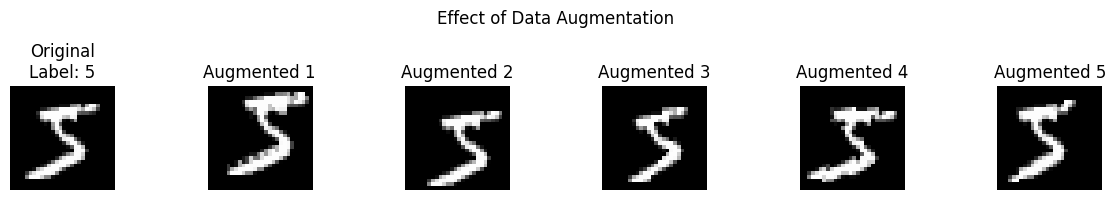

In [29]:
show_augmentation_effect()

Since the effects are randomized, running this several times will yield different results. 

## 4. CNN Architecture

The specific values chosen are standard for the MNIST dataset and CNN training.

1. **First convolution:** Scans the image with 32 small kernels (3×3) to detect simple patterns like edges and curves.
2. **ReLU activation:** Keeps positive values, turns negatives to zero. This adds non-linearity, letting the network learn complex patterns. Since only adding 
3. **MaxPooling:** Shrinks the image by half (28 pixels become 14), keeping the strongest activations. This helps the model with generalization.
4. **Second convolution:** 64 kernels look for combinations of the simple patterns from the first step (curves becoming loops, edges becoming corners)
5. **Second MaxPooling:** Shrinks the image by half again (14 layers become 7), keeping the strongest activations.
6. **Flatten:** Converts the 2D feature maps (64×7×7) into a 1D list (3136 values) so it can feed into dense layers
7. **Fully connected layers:** Look at all detected patterns together to decide which digit it is. The 128-neuron layer can be though of as a "thinking" step before the final 10-neuron output (one per digit)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        #First convolution, in channel = 1 because it's a grayscale image. 
        #Using a standard 32 kernels which are 3x3 pixels 
        #And a padding border of 1 to keep output the same size:
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        #Maxpooling to shrink the image, this shrinks it by half the pixel size so 28->14 first time
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Second convolution, in channels = 32 since we used 32 kernels for the first layer
        #Outputting more kernels to capture more complex patterns from the previous kernels :
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        #Fully connected layers looking at every input pattern from the second convolution
        #Intermediate step for connecting all the input before the output step
        #128 is a standard choice for MNIST
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        #Finals layer, shrinking to 10 outputs, one score for each digit
        self.fc2 = nn.Linear(128, 10)
        
        #Activation function that keeps positive values and turns negative to 0
        self.relu = nn.ReLU()

    def forward(self, x):
        #First block: Convolution -> Relu -> Maxpool
        x = self.conv1(x)    # (1, 28, 28) → (32, 28, 28)
        x = self.relu(x)
        x = self.pool(x)     # (32, 28, 28) → (32, 14, 14)
        
        #Second block: Convolution -> Relu -> Maxpool
        x = self.conv2(x)    # (32, 14, 14) → (64, 14, 14)
        x = self.relu(x)
        x = self.pool(x)     # (64, 14, 14) → (64, 7, 7)
        
        #Flatten for fully connected layers
        x = x.view(-1, 64 * 7 * 7)  # (64, 7, 7) → (3136,)
        
        #Fully connected layers
        x = self.fc1(x)      # (3136,) → (128,)
        x = self.relu(x)
        x = self.fc2(x)      # (128,) → (10,)
        
        return x

#Create the model instance
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


## 5. Model Training

In [ ]:

#DataLoaders bundle images into batches for efficient training
#Config is based on the constants in the top of the Notebook
#Shuffle randomizes the order each epoch which helps learning if the dataset is ordered (which i don't think MNIST is)
train_loader = DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#Loss function measures how wrong the predictions are
#If the model is confidently wrong -> larger loss
criterion = nn.CrossEntropyLoss()

#Optimizer: adjusts the model weights to reduce loss
#Adam seems popular for MNIST
#lr defines how steady the training is, higher values might go faster but overshoot
#While smaller lr might be too slow.
#0.001 is a standard starting point for Adam
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Training loop
for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    #Loggin these to figure out loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        #Clear the gradients from the previous batch
        optimizer.zero_grad()
        
        #Forward pass, getting predictions for the batch
        outputs = model(images)
        
        #Calculate loss
        loss = criterion(outputs, labels)
        
        #Backward pass, calculate gradients to figure out what to change to improve the model
        loss.backward()
        
        #Actually implementing the adjustment by updating the weights
        optimizer.step()
        
        #Track statistics
        running_loss += loss.item() #The average loss of the batch summing up
        _, predicted = torch.max(outputs, 1) #Extracting all the predictions of the batch
        total += labels.size(0) #Counting how many images has been seen 
        correct += (predicted == labels).sum().item() #Comparing predictions with correct labels
    
    #Print progress after each epoch
    epoch_loss = running_loss / len(train_loader) #All of the batches avarage loss combined devided by the amount of batches
    epoch_acc = 100 * correct / total #Calculate procentage
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%")

print("Training complete!")

Epoch 1/10 - Loss: 0.3356 - Accuracy: 89.23%
Epoch 2/10 - Loss: 0.1033 - Accuracy: 96.74%
Epoch 3/10 - Loss: 0.0761 - Accuracy: 97.59%
Epoch 4/10 - Loss: 0.0665 - Accuracy: 97.90%
Epoch 5/10 - Loss: 0.0574 - Accuracy: 98.16%
Epoch 6/10 - Loss: 0.0538 - Accuracy: 98.30%
Epoch 7/10 - Loss: 0.0474 - Accuracy: 98.44%
Epoch 8/10 - Loss: 0.0438 - Accuracy: 98.61%
Epoch 9/10 - Loss: 0.0421 - Accuracy: 98.66%
Epoch 10/10 - Loss: 0.0402 - Accuracy: 98.69%
Training complete!


## 6. Model Evaluation

Now let's evaluate the model by running the classification report which will give us:

1. **Precision** - Correct positive predictions / all predicted positives
2. **Recall** - Correct positives / all actual positives
3. **F1-score** - Combination of Precision and Recall
4. **Support** - How many of each digit

In [42]:
model.eval()  # Set model to evaluation mode, not strictly necessary but good practice

all_predictions = []
all_labels = []

# No gradients needed for evaluation, saves memory for inferance
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

# Print classification report with precision, recall, f1-score
print("Classification Report:")
print(classification_report(all_labels, all_predictions, digits=3))

Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.998     0.994       980
           1      0.991     0.998     0.995      1135
           2      0.997     0.984     0.991      1032
           3      0.991     0.998     0.995      1010
           4      0.995     0.985     0.990       982
           5      0.992     0.993     0.993       892
           6      0.997     0.984     0.991       958
           7      0.984     0.991     0.987      1028
           8      0.997     0.988     0.992       974
           9      0.980     0.993     0.987      1009

    accuracy                          0.991     10000
   macro avg      0.992     0.991     0.991     10000
weighted avg      0.991     0.991     0.991     10000



**What the classification report says:**

The model is quite strong with an accuracy of around 99.1%

We can see that the digits, 2, 6 and 8 have the highest precision. Likely because of their distinct shapes. While 9 has the lowest probably because it's visually similar to 4. 

And creating a confusion matrix which will help us visualize which predictions where wrong and what they predicted: 

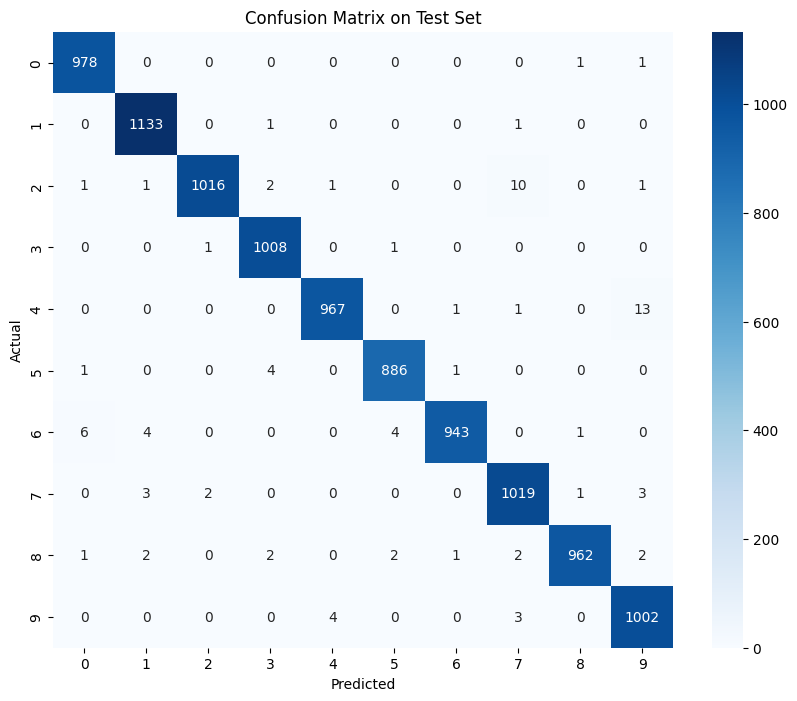

In [37]:
# Confusion matrix visualization
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

**What the confusion matrix says:**

The confusion matrix shows most predictions on the diagonal (these are all correct), with a few scattered misses. The most common errors are:

- 4 confused with 9
- 2 confused with 7
- 6 confused with 0 

## 7. Error Analysis

In [39]:
# Find misclassified images
misclassified_indices = []
misclassified_predictions = []
misclassified_labels = []

model.eval()
with torch.no_grad():
    for i, (image, label) in enumerate(test_dataset):
        output = model(image.unsqueeze(0))  # Add batch dimension
        _, predicted = torch.max(output, 1)
        
        if predicted.item() != label:
            misclassified_indices.append(i)
            misclassified_predictions.append(predicted.item())
            misclassified_labels.append(label)

print(f"Total misclassified: {len(misclassified_indices)} out of {len(test_dataset)}")

Total misclassified: 86 out of 10000


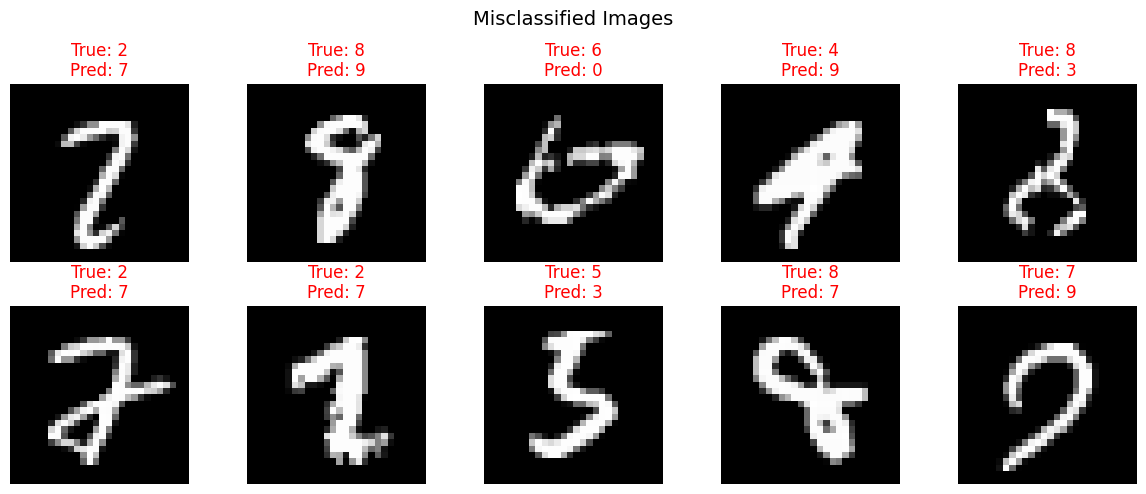

In [41]:
# Show first 10 misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(misclassified_indices):
        idx = misclassified_indices[i]
        image, true_label = test_dataset[idx]
        pred_label = misclassified_predictions[i]
        
        ax.imshow(image.squeeze(), cmap="gray")
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color='red')
        ax.axis("off")

plt.suptitle("Misclassified Images", fontsize=14)
plt.tight_layout()
plt.show()

Looking at these misclassified images we can see that most errors occur on poorly written digits, or ones that would be hard for humans to interpret as well. 

Most of the guesses look quite reasonable and this might mean that we are approaching the practical limit of what's achievable on the MNIST dataset. From my research, state of the art models can achieve upwards of around 99.8% accuracy. So there are improvement to be made to this simple CNN.